In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import yfinance as yf

from model.PDV import *
from model.HMM import *
from model.data import *

# Data

In [2]:
window = 1000
log_return = True
predict_t_plus_1 = False
regular_periods = True
multi_index_fit = True

In [3]:
start_date = pd.to_datetime('1995-01-01')
end_date = pd.to_datetime('2023-08-31')
spx_data = pd.read_csv('./data/spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('./data/vix_data_nn.csv', index_col=0, parse_dates=[0])
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)
data = create_df_from_yf(spx_data, start_date, end_date, vix_data, predict_t_plus_1=predict_t_plus_1, log_return=log_return)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2023-08-24,-0.013549,1.835850e-04,0.1720
2023-08-25,0.006696,4.482973e-05,0.1568
2023-08-28,0.006245,3.900101e-05,0.1508
2023-08-29,0.014404,2.074772e-04,0.1445


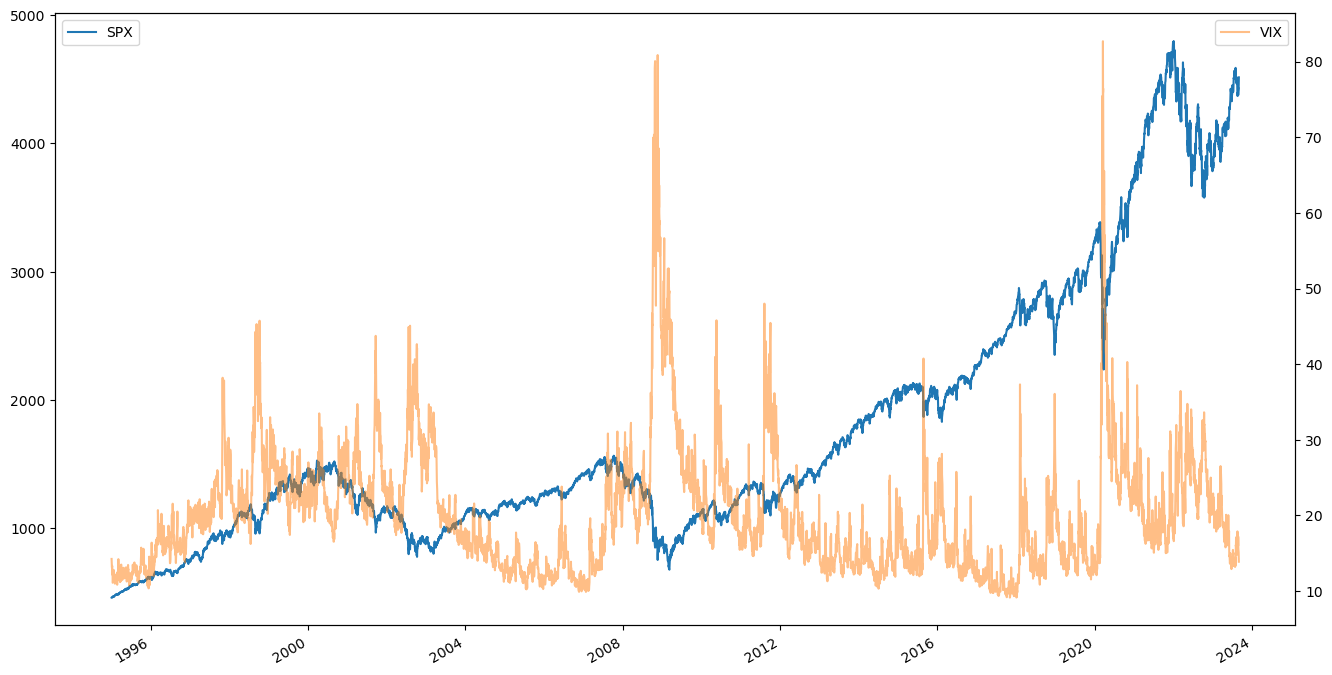

In [4]:
fig, ax = plt.subplots(figsize=(16,9))
spx_data[['Close']].plot(ax=ax, label='SPX')
ax2 = vix_data[['Close']].plot(ax=ax, label='VIX', secondary_y=True, alpha=0.5)
ax.legend(labels=['SPX'], loc='upper left')
ax2.legend(labels=['VIX'], loc='upper right')

In [5]:
# merged_df = pd.merge(spx_data['Close'], vix_data['Close'] / 100, left_index=True, right_index=True, )
# merged_df.rename(columns={'Close_x': 'SPX', 'Close_y': 'VIX'}, inplace=True)
# merged_df.to_csv('./data/spx_vix_df.csv')
# merged_df

# HMM for SPX

## Irregular time periods

In [6]:
if not regular_periods:
    for n in range(2, 6): # set end range to 2 to stop code running
        n_regimes = n
        spx_models = []
        print(f'Number of regimes: {n_regimes}')

        for i in range(1, 6):
            print(f'Run {i}')
            spx_model = IrregularPeriodsHMM(n_regimes, verbose=False)
            print(f'Initial parameters μ: {spx_model.μ}, σ: {spx_model.σ}, π: {np.exp(spx_model.π)}, A: \n{np.exp(spx_model.A)}')
            spx_model.EM_optimise(spx_data, tol=1e-7)
            spx_models.append(spx_model)
            spx_model.print_params()

            # save params to dataframe and csv
            spx_model.save_params_to_csv('./dataparams.csv', i)
            print('----------------------------------')

In [7]:
if not regular_periods:
    df = pd.read_csv('./data/params_v1.csv', index_col=0, converters={'μ': from_np_array, 'σ': from_np_array,
                                                            'π': from_np_array, 'A': from_np_array,
                                                            'π_alpha': from_np_array, 'A_alpha': from_np_array})
    df

In [8]:
if not regular_periods:
    n_regimes = 4
    model_num = 3
    spx_model = IrregularPeriodsHMM(n_regimes, verbose=False)
    spx_model.load_params_from_csv('./data/params_v1.csv', model_num)
    spx_model.predict(spx_data)

In [9]:
if not regular_periods:
    spx_model.plot_regimes_on_index()

## Regular time periods (using hmmlearn)

### Using SPX + UKX + DAX to train

In [10]:
# start_date = pd.to_datetime('1995-01-04')
# end_date = pd.to_datetime('2023-08-31')
# tickers = ['^GSPC', '^FTSE', '^GDAXI']
# # download data from yahoo finance
# hmm_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
# hmm_data = hmm_data['Adj Close']
# hmm_data.dropna(inplace=True)
# hmm_data = hmm_data / hmm_data.iloc[0]
# hmm_data = hmm_data[tickers] # reorder columns so that first column is SPX

Model is not converging.  Current: 70976.26443405214 is not greater than 70976.33266542229. Delta is -0.0682313701545354


Model score: 70976.1386
Model score: 70880.5485
Model score: 70968.5895
Model score: 70876.3225
Model score: 70898.3685


Model is not converging.  Current: 70920.44280221942 is not greater than 70920.51942766472. Delta is -0.0766254453046713


Model score: 70920.2773
Model score: 70827.3678
Model score: 70883.4671
Best model: 0
Regime 0 count: 1186
Regime 1 count: 3052
Regime 2 count: 2579
Regime 3 count: 180
μ: [[-0.08311075 -0.09972094 -0.14721541]
 [ 0.31700458  0.18984631  0.36203423]
 [-0.01281785  0.01176596  0.00673609]
 [-0.55383414 -0.70754946 -1.15059054]]
σ: [[0.26780827 0.26580672 0.35140098]
 [0.09322681 0.10007257 0.12727071]
 [0.17514759 0.1634939  0.20833158]
 [0.64145894 0.5557479  0.64080523]]
Drift: [[-0.11897139 -0.13504754 -0.20895674]
 [ 0.31265896  0.18483905  0.35393532]
 [-0.02815619 -0.00159917 -0.01496494]
 [-0.75956893 -0.86197732 -1.35590621]]
Transition:
[[9.35197215e-01 9.39737254e-06 4.64776295e-02 1.83157585e-02]
 [4.85920466e-05 9.56436088e-01 4.35153199e-02 3.07825234e-42]
 [2.08516058e-02 4.93967509e-02 9.29751643e-01 3.29381022e-11]
 [1.13112375e-01 6.44536998e-42 1.00857956e-11 8.86887625e-01]]
Initial state distribution: [6.80730822e-149 1.00000000e+000 1.53521872e-084 3.75066888e-276]


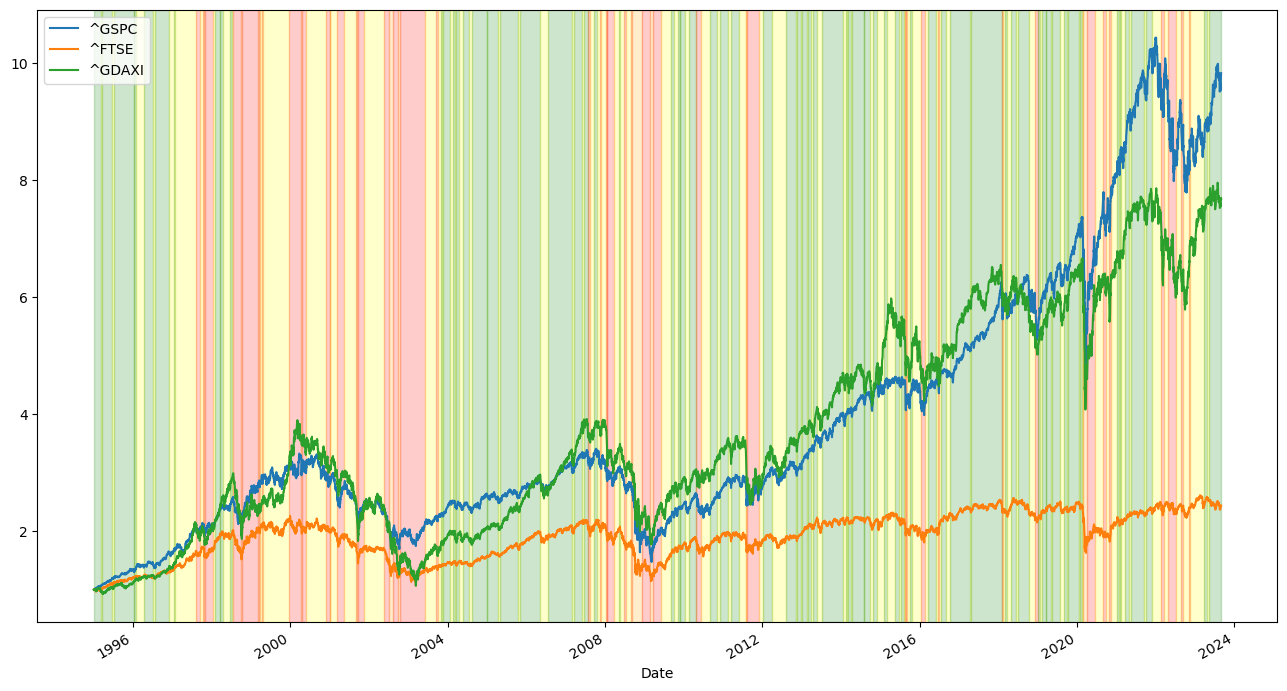

In [11]:
if regular_periods and multi_index_fit:
    hmm_data = pd.read_csv('./data/spx_ukx_dax_data.csv', index_col=0, parse_dates=[0])
    n_regimes = 4
    n_models = 8
    spx_model = RegularPeriodsHMM(n_regimes, n_models=8, verbose=False)
    spx_model.fit(hmm_data, hmm_data.columns)

### Using SPX alone

In [12]:
if regular_periods and not multi_index_fit:
    n_regimes = 4
    n_models = 8
    spx_model = RegularPeriodsHMM(n_regimes, n_models=8, verbose=False)
    spx_model.fit(spx_data)

### Simulate

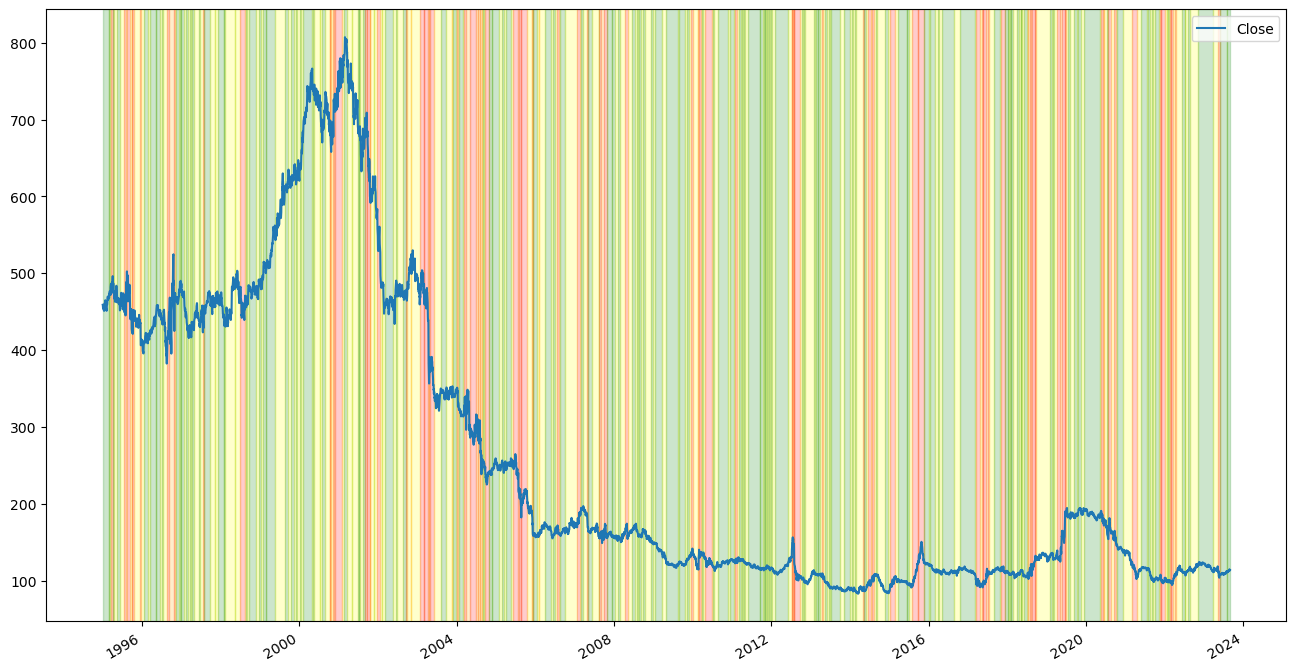

In [13]:
sim_df = spx_model.simulate(spx_data.loc[spx_data.index[0], 'Close'], spx_data.index)

# PDV model for VIX

In [14]:
pdv_initial_params = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
vix_model = PDV2Exp(pdv_initial_params)
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
vix_model.optimise(data, window, lower_bound=lower_bound, upper_bound=upper_bound)
print(vix_model.params)
vix_model.evaluate(data, window)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9078e+00                                    3.06e+01    
       1              2         1.7759e+00      1.32e-01       3.63e+00       1.18e+01    
       2              3         1.7013e+00      7.46e-02       2.94e+00       2.39e-01    
       3              4         1.7002e+00      1.04e-03       1.46e+00       4.28e-01    
       4              5         1.7001e+00      1.68e-04       2.17e+00       4.07e-02    
       5              6         1.7000e+00      1.75e-05       8.13e-01       1.12e-02    
       6              7         1.7000e+00      4.01e-06       5.28e-01       3.32e-03    
       7              8         1.7000e+00      1.22e-06       2.84e-01       9.84e-04    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.9078e+00, final cost 1.7000e+00, first-order optimality 9.84e-04.
[ 5.40639378e-02 -5.64113523e-02 

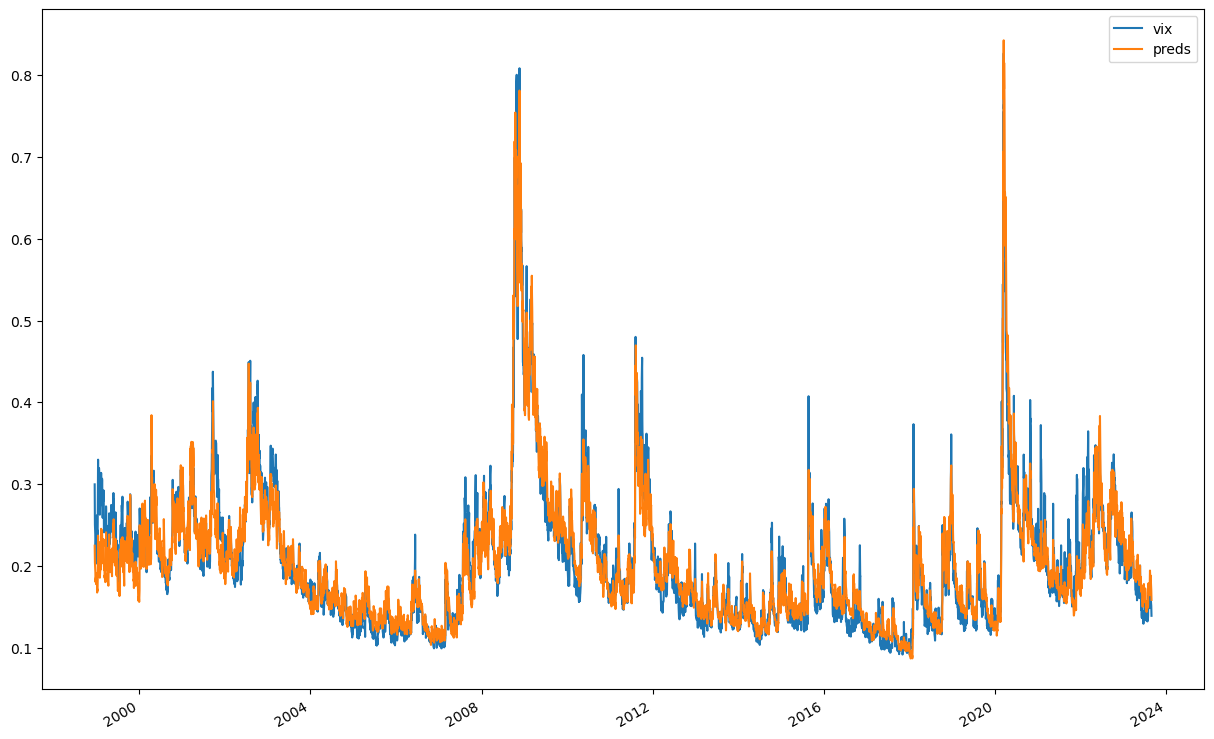

In [15]:
vix_model.plot(data, window)

# Simulate SPX + VIX

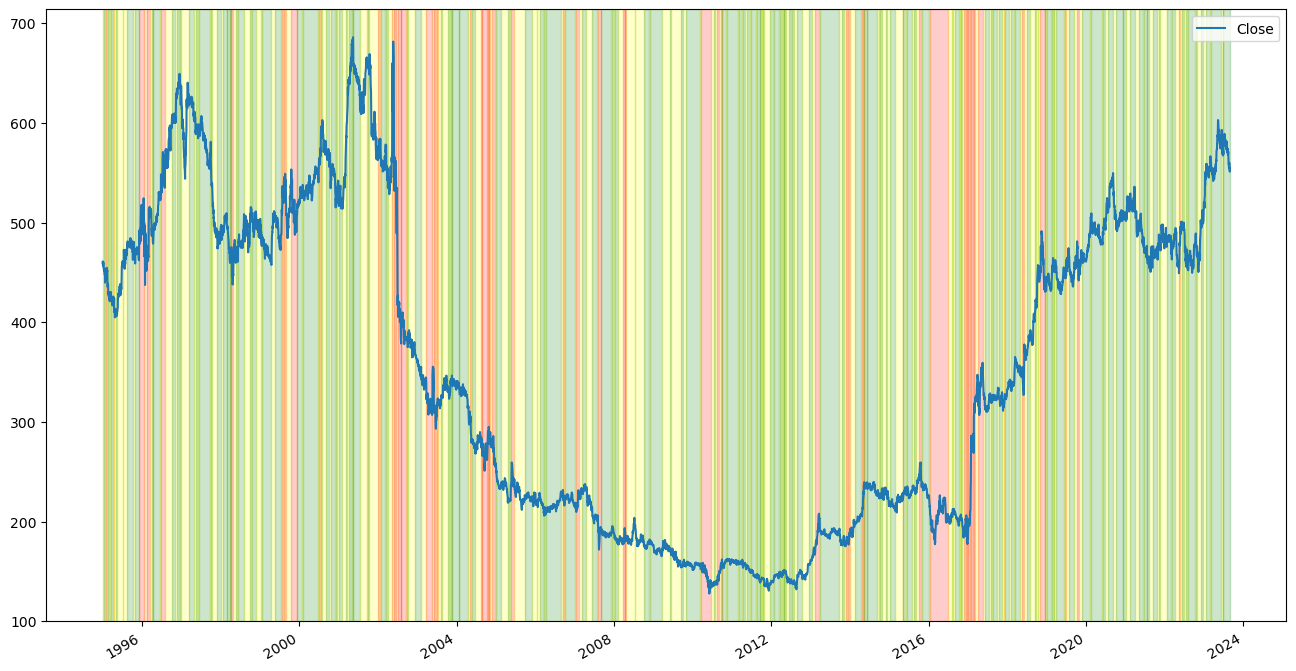

In [16]:
# sim_df = spx_model.simulate(return_df=True)
sim_df = spx_model.simulate(spx_data.loc[spx_data.index[0], 'Close'], spx_data.index)

In [17]:
r_df = create_df_from_yf(sim_df, sim_df.index[0], sim_df.index[-1]+pd.Timedelta(days=1), predict_t_plus_1=predict_t_plus_1, log_return=log_return)
r_df.drop_duplicates(inplace=True)
vix = vix_model.predict(r_df, window).numpy()
vix = list(np.zeros(window-1)) + list(vix)
sim_df['VIX'] = vix

In [18]:
sim_df

,Close,VIX
1995-01-03,459.109985,0.000000
1995-01-04,461.019830,0.000000
1995-01-05,458.288820,0.000000
1995-01-06,456.354587,0.000000
1995-01-09,460.221919,0.000000
...,...,...
2023-08-24,559.897403,0.151448
2023-08-25,556.392540,0.157911
2023-08-28,551.073808,0.165469
2023-08-29,552.615807,0.160130


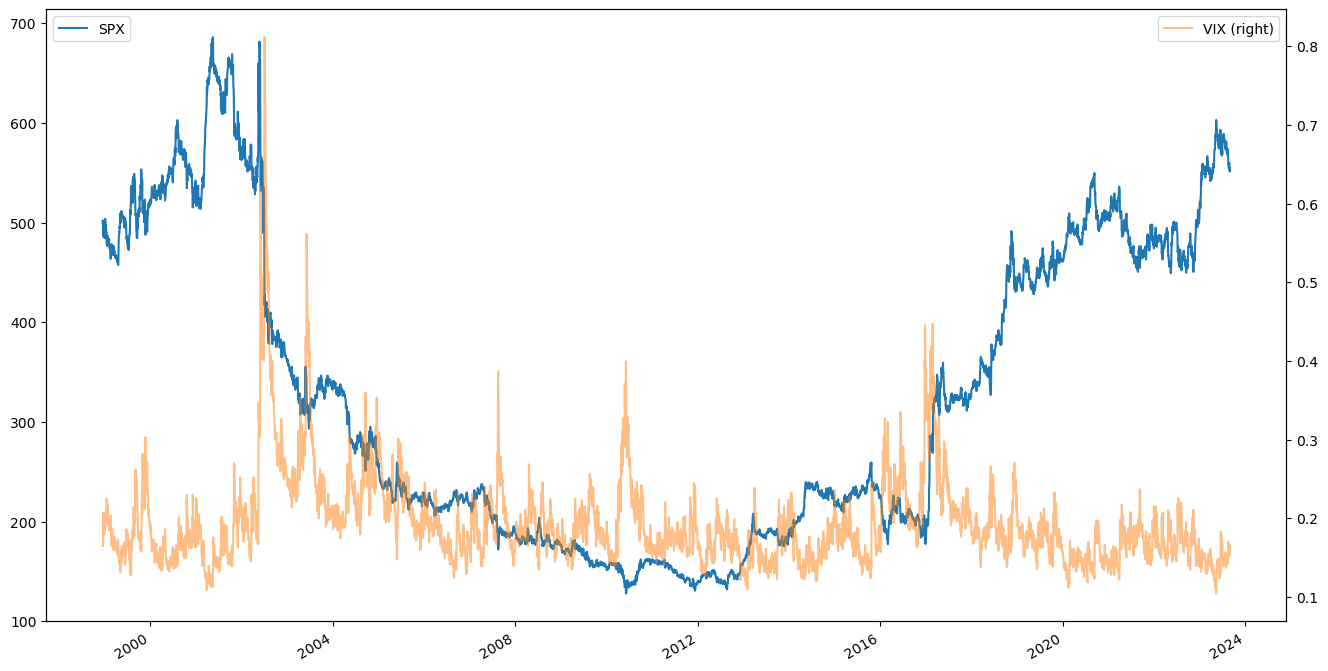

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
sim_df.columns = ['SPX', 'VIX']
sim_df.loc[sim_df.index[window-1:], 'SPX'].plot(ax=ax)
sim_df.loc[sim_df.index[window-1:], 'VIX'].plot(ax=ax, secondary_y=True, alpha=0.5)
ax.legend(loc='upper left')
plt.legend()

In [20]:
# sim_df.to_csv('./data/sim_df_v1.csv')

# Batch simulation and save data

In [47]:
n_samples = 10 # number of spx+vix samples to generate
spx_samples = spx_model.batch_simulate(n_samples, spx_data.loc[spx_data.index[0], 'Close'], spx_data.index) # simulate spx data
print(f'SPX sample shape: spx_samples.shape')
features = batch_create_df_from_yf(spx_samples, log_return=False) # create r1 and r2 features from spx data
print(f'Features shape: {features.shape}')
vix_samples = vix_model.batch_predict(features, spx_data.index[1:], window, return_numpy=True) # predict vix data from features
print(f'VIX sample shape: {vix_samples.shape}')
combined_samples = np.stack((spx_samples[:, -vix_samples.shape[-1]:], vix_samples), axis=-1)
print(f'Combined sample shape: {combined_samples.shape}')

SPX sample shape: spx_samples.shape
Features shape: (10, 7215, 2)
VIX sample shape: (10, 6216)
Combined sample shape: (10, 6216, 2)


In [33]:
np.save('./data/sim_samples_v1.npy', combined_samples)

(10, 7215, 2)